Dados ozonio 

Latitude e longitude step: 0.5 graus

In [1]:
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon


In [3]:
file_name = '~/MarcoFranco/Copernicus_Ozone/202103-C3S-L4_OZONE-O3_PRODUCTS-MSR-ASSIM-ALG-MONTHLY-v0024.nc'

nc_file = xr.open_dataset(file_name)


<xarray.Dataset>
Dimensions:                                (longitude: 720, latitude: 361,
                                            time: 1)
Coordinates:
  * longitude                              (longitude) float32 -179.5 ... 180.0
  * latitude                               (latitude) float32 -90.0 ... 90.0
  * time                                   (time) datetime64[ns] 2021-03-15
Data variables:
    total_ozone_column                     (time, latitude, longitude) float32 ...
    total_ozone_column_standard_deviation  (time, latitude, longitude) float32 ...
Attributes: (12/19)
    Authors:                  Marc Allaart and Ronald van der A
    Affiliation:              KNMI (Royal Netherlands Meteorological Institute)
    Email:                    allaart@knmi.nl
    Data_created_by:          TM3-DAM (version 3.3)
    Ozone_field_date:         [2021    3]
    Date_format:              year, month
    ...                       ...
    Field_Average_O3_std:     Standard deviation of monthly average ozone column
    Units:                    Dobson units
    Undefined_value:          0
    Datafile_generated_at:    25 February 2022 
    Note:                     GZIP compressed 2-byte integer arrays
    id:                       C3S_OZONE-L4-TC-ASSIM_MSR-202103-fv0024.nc

In [29]:
'''
long_name :
Monthly average of ozone column distribution
standard_name :
atmosphere_mole_content_of_ozone
units :
Dobson units
'''


total_o3_column = nc_file[[
    'time',
    'longitude',
    'latitude',
    'total_ozone_column'
]]

# convert to dataframe
total_o3_column.rio.set_crs("epsg:4326")
df = total_o3_column.to_dataframe()
df = df.reset_index()
df.rename(columns = {'longitude':'lon', 'latitude':'lat'}, inplace = True)

df

,time,lon,lat,total_ozone_column
0,2021-03-15,-179.5,-90.0,255.0
1,2021-03-15,-179.5,-89.5,255.0
2,2021-03-15,-179.5,-89.0,254.0
3,2021-03-15,-179.5,-88.5,255.0
4,2021-03-15,-179.5,-88.0,255.0
...,...,...,...,...
259915,2021-03-15,180.0,88.0,378.0
259916,2021-03-15,180.0,88.5,378.0
259917,2021-03-15,180.0,89.0,378.0
259918,2021-03-15,180.0,89.5,378.0


In [16]:
#
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

points = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [28]:
# filter lat and long

# to avoid excessive processing to shapefiles we define a box
# covering South America


min_lat = -57.5858
max_lat =  15.5988
min_lon = -85.8360
max_lon = -35.8750

# back to original nomenclature
tmp = points.copy()

lat_filter = (tmp["latitude"] >= min_lat) & (tmp["latitude"] <= max_lat)
lon_filter = (tmp["longitude"] >= min_lon) & (tmp["longitude"] <= max_lon)

# tmp = tmp.loc[lat_filter & lon_filter]

points = tmp[lat_filter & lon_filter]
points.size

88200

In [20]:
# adjust the buffer to the 0.5 x 0.5 grid

buffers = points.buffer(0.25)
bounds = buffers.bounds

bounds['pixel_area'] = bounds.apply(
  lambda obj: Polygon(shell=[
    Point(obj['maxx'],obj['miny']),
    Point(obj['minx'],obj['miny']),
    Point(obj['minx'],obj['maxy']),
    Point(obj['maxx'],obj['maxy']),
    Point(obj['maxx'],obj['miny']),
  ]),
  axis=1
)

# adding indexes to merge dataframes
points.insert(0, 'New_ID', range(1, 1 + len(points)))
bounds.insert(0, 'New_ID', range(1, 1 + len(bounds)))

my_merge = bounds.merge(points, on='New_ID')


/tmp/ipykernel_43010/697118290.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffers = points.buffer(0.25)


In [25]:
# new geodataframe with the gridded points

gdf = my_merge
gdf = gpd.GeoDataFrame(
    gdf,
    crs = {'init':'EPSG:4326'}, 
    geometry = [a for a in gdf['pixel_area']]                               
    )
gdf = gdf.reset_index()
gdf = gdf.loc[:,gdf.columns.isin(['total_ozone_column', 'geometry'])]

/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'O3 (Dobson Units)')

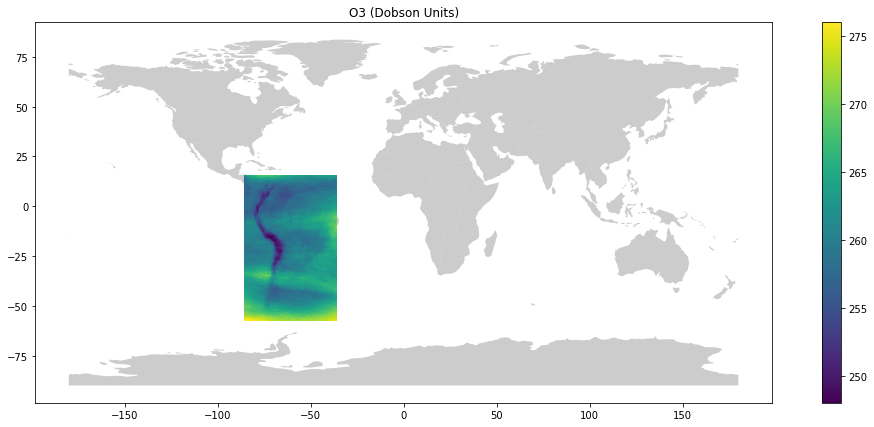

In [26]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(18, 7))
world.plot(ax=ax, alpha=0.4, color='grey')
gdf.plot(column='total_ozone_column', ax=ax, legend=True)

plt.title('O3 (Dobson Units)')


In [321]:
gdf.to_file(
    '../data/output/oco2_LtCO2_190802_B10206Ar_200729204909s.shp')


/tmp/ipykernel_98639/2080762541.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(
